In [14]:
import gymnasium as gym
from bettermdptools.envs.cartpole_wrapper import CartpoleWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
import numpy as np
import matplotlib.pyplot as plt
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.decorators import add_to
import seaborn as sns

# Value Iteration

In [33]:
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(base_env)

V, V_track, V_pi = Planner(cartpole.P).value_iteration(gamma=0.99, n_iters=1000, theta=1e-3)

test_scores = TestEnv.test_env(env=cartpole, n_iters=100, render=False, pi=V_pi, user_input=False)
print(np.mean(test_scores))

9.41


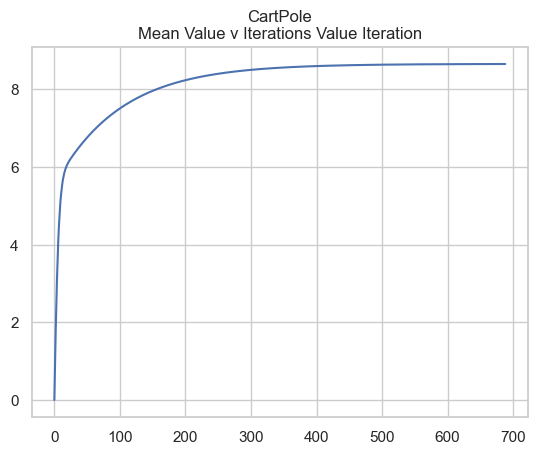

In [34]:
max_value_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "CartPole\nMean Value v Iterations Value Iteration")

Policy Iteration converged at iteration: 690


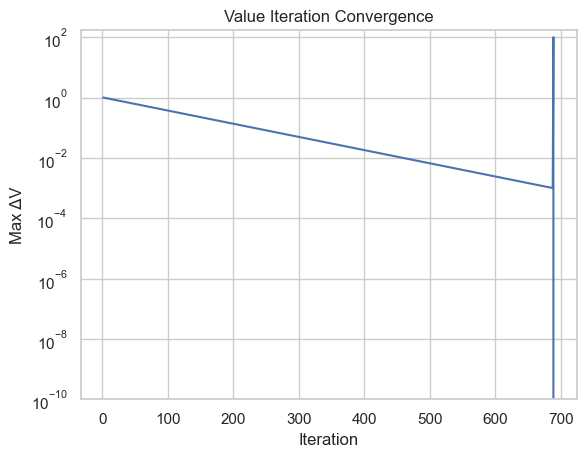

In [36]:
def detect_convergence(V_track, theta=1e-10):
    diffs = np.abs(V_track[1:] - V_track[:-1])
    max_diffs = np.max(diffs, axis=1)
    for i, d in enumerate(max_diffs):
        if d < theta:
            return i + 1
    return len(max_diffs)

converged_iter = detect_convergence(V_track, theta=1e-10)
print(f"Policy Iteration converged at iteration: {converged_iter}")


def plot_convergence(P_track, theta=1e-10):
    diffs = np.abs(P_track[1:] - P_track[:-1])
    max_diffs = np.max(diffs, axis=1)

    cutoff = np.argmax(max_diffs < theta) + 1
    max_diffs_trimmed = max_diffs[:cutoff]

    plt.plot(range(1, cutoff + 1), max_diffs_trimmed)
    plt.xlabel("Iteration")
    plt.ylabel("Max ΔV")
    plt.title("Value Iteration Convergence")
    plt.yscale("log")
    plt.ylim(bottom=1e-10)
    plt.grid(True)
    plt.show()

plot_convergence(V_track, theta=1e-10)

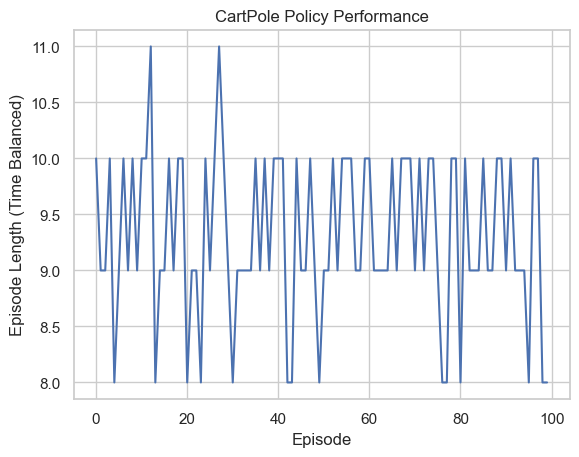

Average episode length: 9.31


In [39]:
def evaluate_policy_tabular(env, policy, n_episodes=100):
    lengths = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_steps = 0

        while not done:
            state = int(obs)
            action = policy.get(state, env.action_space.sample())
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_steps += 1

        lengths.append(total_steps)

    return lengths

episode_lengths = evaluate_policy_tabular(cartpole, V_pi, n_episodes=100)

plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length (Time Balanced)")
plt.title("CartPole Policy Performance")
plt.grid(True)
plt.show()

print(f"Average episode length: {np.mean(episode_lengths):.2f}")

# Policy Iteration

In [25]:
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(base_env)

P, P_track, P_pi = Planner(cartpole.P).policy_iteration(gamma=0.99, n_iters=50, theta=1e-3)

test_scores = TestEnv.test_env(env=cartpole, n_iters=100, render=False, pi=P_pi, user_input=False)
print(np.mean(test_scores))


9.41


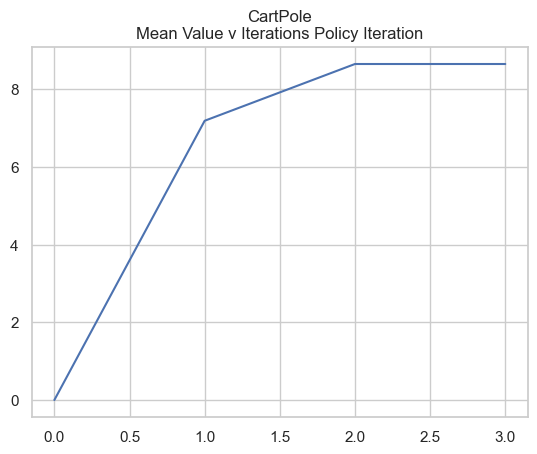

In [26]:
max_value_per_iter = np.trim_zeros(np.mean(P_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "CartPole\nMean Value v Iterations Policy Iteration")

Policy Iteration converged at iteration: 5


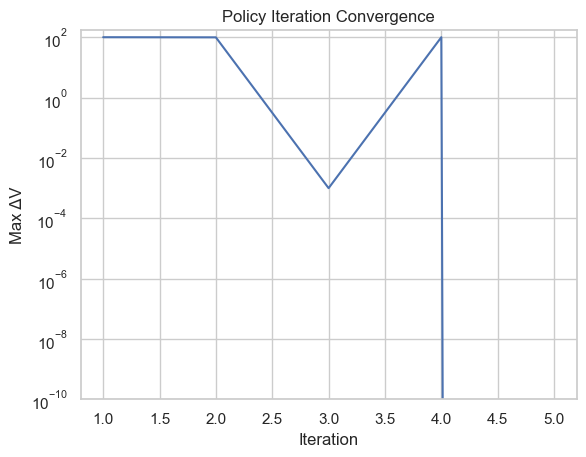

In [40]:
def detect_convergence(V_track, theta=1e-10):
    diffs = np.abs(V_track[1:] - V_track[:-1])
    max_diffs = np.max(diffs, axis=1)
    for i, d in enumerate(max_diffs):
        if d < theta:
            return i + 1
    return len(max_diffs)

converged_iter = detect_convergence(P_track, theta=1e-10)
print(f"Policy Iteration converged at iteration: {converged_iter}")


def plot_convergence(P_track, theta=1e-10):
    diffs = np.abs(P_track[1:] - P_track[:-1])
    max_diffs = np.max(diffs, axis=1)

    cutoff = np.argmax(max_diffs < theta) + 1
    max_diffs_trimmed = max_diffs[:cutoff]

    plt.plot(range(1, cutoff + 1), max_diffs_trimmed)
    plt.xlabel("Iteration")
    plt.ylabel("Max ΔV")
    plt.title("Policy Iteration Convergence")
    plt.yscale("log")
    plt.ylim(bottom=1e-10)
    plt.grid(True)
    plt.show()

plot_convergence(P_track, theta=1e-10)

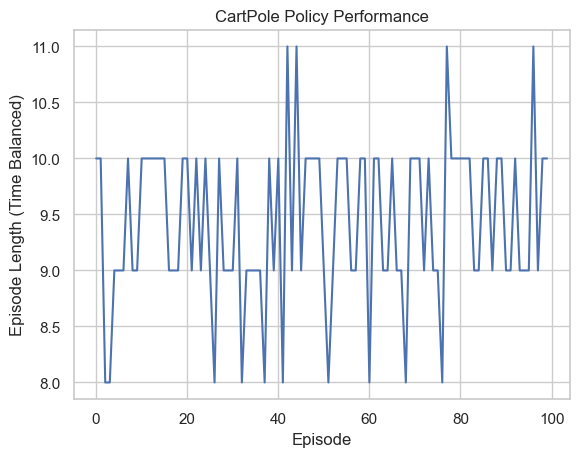

Average episode length: 9.43


In [44]:
def evaluate_policy_tabular(env, policy, n_episodes=100):
    lengths = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_steps = 0

        while not done:
            state = int(obs)
            action = policy.get(state, env.action_space.sample())
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_steps += 1

        lengths.append(total_steps)

    return lengths

episode_lengths = evaluate_policy_tabular(cartpole, P_pi, n_episodes=100)

plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length (Time Balanced)")
plt.title("CartPole Policy Performance")
plt.grid(True)
plt.show()

print(f"Average episode length: {np.mean(episode_lengths):.2f}")

In [42]:
def compare_policies(pi_value, pi_policy):
    all_states = set(pi_value.keys()).union(set(pi_policy.keys()))
    mismatches = []

    for s in all_states:
        a_value = pi_value.get(s)
        a_policy = pi_policy.get(s)
        if a_value != a_policy:
            mismatches.append((s, a_value, a_policy))

    if not mismatches:
        print("✅ Value Iteration and Policy Iteration produce the SAME policy.")
    else:
        print(f"❌ Policies differ at {len(mismatches)} states.")
        print("Examples (state, value_iter_action, policy_iter_action):")
        for m in mismatches[:10]:
            print(m)

compare_policies(P_pi, V_pi)

❌ Policies differ at 125 states.
Examples (state, value_iter_action, policy_iter_action):
(1388, 1, 0)
(1395, 1, 0)
(1415, 1, 0)
(1425, 1, 0)
(1455, 1, 0)
(1465, 1, 0)
(1475, 1, 0)
(1625, 1, 0)
(1645, 1, 0)
(1685, 1, 0)


# Episode Over Time

In [79]:
def track_policy_learning(env, planner, gamma=0.99, theta=1e-3, max_iters=50, eval_episodes=100):

    avg_lengths = []
    
    random_actions = np.random.choice(tuple(planner.P[0].keys()), len(planner.P))
    pi = {s: a for s, a in enumerate(random_actions)}
    V = np.zeros(len(planner.P))

    for i in range(max_iters):
        V = planner.policy_evaluation(pi, V, gamma=gamma, theta=theta)

        new_pi = planner.policy_improvement(V, gamma=gamma)

        avg_len = np.mean(evaluate_policy_tabular(env, policy=new_pi, n_episodes=eval_episodes))
        avg_lengths.append(avg_len)
        print(f"Iteration {i+1}: Avg Episode Length = {avg_len:.2f}")

        if pi == new_pi:
            print("Policy converged.")
            break

        pi = new_pi

    return avg_lengths


Iteration 1: Avg Episode Length = 9.28
Iteration 2: Avg Episode Length = 9.41
Iteration 3: Avg Episode Length = 9.37
Policy converged.


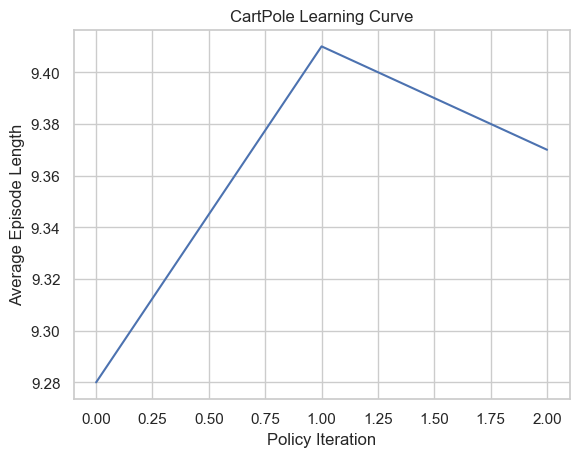

In [80]:
avg_lengths = track_policy_learning(env=cartpole, planner=Planner(cartpole.P))

plt.plot(avg_lengths)
plt.xlabel("Policy Iteration")
plt.ylabel("Average Episode Length")
plt.title("CartPole Learning Curve")
plt.grid(True)
plt.show()

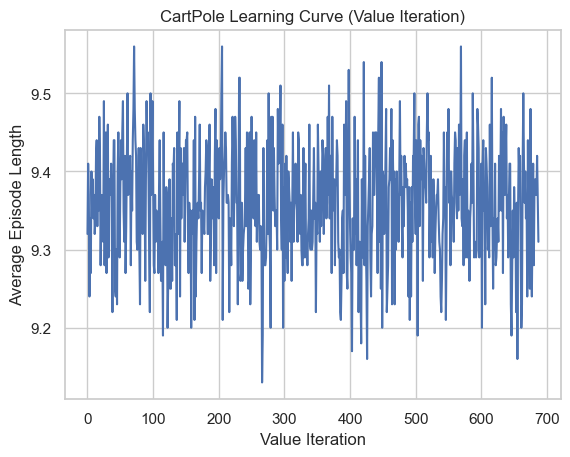

In [51]:
def track_value_learning(V_track, env, planner, gamma=0.99, theta=1e-3, max_iters=1000, eval_episodes=100):

    avg_lengths = []

    for i in range(1, max_iters):
        if not np.any(V_track[i]):
            break

        V_i = V_track[i]
        pi_i = planner.policy_improvement(V_i, gamma=gamma)

        avg_len = np.mean(evaluate_policy_tabular(env, pi_i, n_episodes=eval_episodes))
        avg_lengths.append(avg_len)

    return avg_lengths

avg_lengths_val_iter = track_value_learning(V_track, env=cartpole, planner=Planner(cartpole.P))

plt.plot(avg_lengths_val_iter)
plt.xlabel("Value Iteration")
plt.ylabel("Average Episode Length")
plt.title("CartPole Learning Curve (Value Iteration)")
plt.grid(True)
plt.show()
